In [1]:
from warnings import simplefilter
simplefilter('ignore')

import sklearn 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import rel_entr
from sklearn.neighbors import KernelDensity
from imblearn.under_sampling import NearMiss, RandomUnderSampler

np.random.seed(10120024)

# Basic Info

In [2]:
data = pd.read_csv('../creditcard.csv')

In [5]:
feature_columns = ['V17', 'V12', 'V14', 'V10', 'V11', 'V16']
target_column = data.columns[-1]

feature_data = data.loc[:, feature_columns]
target_data = data.loc[:, target_column]

target_data[target_data == 0] = -1

# Visualize KL Divergence

In [6]:
kl = []

for feature in data.columns[1:-1]:
    # select fraud and non-fraud data
    fraud_data = data.loc[(target_data.values == 1).reshape(-1, 1).T[0], feature]
    non_fraud_data = data.loc[(target_data.values == -1).reshape(-1, 1).T[0], feature]

    # create kde instance for fraud and non-fraud data
    kde_fraud = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(fraud_data.values.reshape(-1, 1))
    kde_non_fraud = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(non_fraud_data.values.reshape(-1, 1))

    # create a set of numbers
    X = np.linspace(data[feature].min(), data[feature].max(), 100).reshape(-1, 1)

    # calculate the score
    sample_fraud = np.exp(kde_fraud.score_samples(X)) 
    sample_non_fraud = np.exp(kde_non_fraud.score_samples(X))
    sample_fraud /= np.sum(sample_fraud)
    sample_non_fraud /= np.sum(sample_non_fraud)

    # calculate the kl-divergence
    kl.append(sum(rel_entr(sample_fraud, sample_non_fraud)))

In [7]:
kl_data = pd.DataFrame({'Fitur Data':data.columns[1:-1], 
                 'Divergensi KL':kl}).sort_values('Divergensi KL', ascending=False)

fig = plt.figure()
fig.set_size_inches(8, 4)

sns.barplot(data=kl_data, 
               x='Fitur Data',
               y='Divergensi KL',
               palette=['#0a75ad' if val >= 4 else '#c0d6e4' for val in kl_data['Divergensi KL'].values])

plt.xticks(rotation=-45)

plt.savefig('kl_divergence_vis.png')
plt.show()

# Visualize Probability Density

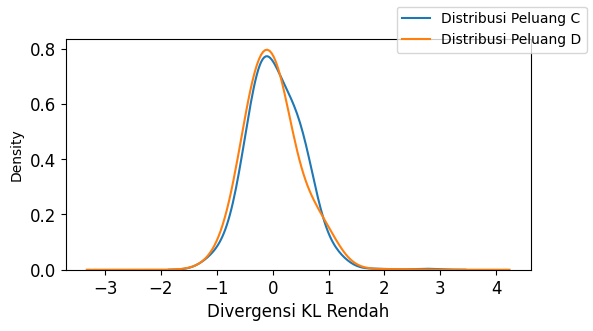

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

for i, feature in enumerate(kl_data['Fitur Data'].values[[-1]]):
    plt.subplot(1, 1, i+1)
    
    sns.kdeplot(data.loc[(target_data.values == 1).reshape(-1, 1).T[0], feature], bw=0.5,label="Class = 1")
    sns.kdeplot(data.loc[(target_data.values == -1).reshape(-1, 1).T[0], feature], bw=0.5,label="Class = -1")

    plt.xlabel('Divergensi KL Rendah', fontsize=12)
    
    plt.tick_params(axis='both', which='major', labelsize=12)

fig.legend(['Distribusi Peluang C', 'Distribusi Peluang D'])
plt.savefig('probability_density_vis_low.png')
plt.show()

In [ ]:
fig, ax = plt.subplots(5, 6, figsize=(30, 10))

for i, feature in enumerate(kl_data['Fitur Data'].values):
    plt.subplot(5, 6, i+1)
    
    sns.kdeplot(data.loc[(target_data.values == 1).reshape(-1, 1).T[0], feature], bw=0.5,label="Class = 1")
    sns.kdeplot(data.loc[(target_data.values == -1).reshape(-1, 1).T[0], feature], bw=0.5,label="Class = -1")
    
    plt.xlabel(feature, fontsize=12)
    
    plt.tick_params(axis='both', which='major', labelsize=12)

fig.legend(['Fraud', 'Tidak Fraud'])
plt.savefig('probability_density_vis.png')
plt.show()

# Undersampling The Data

In [ ]:
undersample = NearMiss(version=3, n_neighbors=10)

feature_sample, target_sample = undersample.fit_resample(feature_data, target_data)
undersampled_data = pd.concat((feature_sample, target_sample), axis=1)

# Train-Test Split

In [ ]:
test_size = 25
undersampled_data_train = pd.concat([
                                    undersampled_data.loc[undersampled_data['Class'] == 1].head(len(undersampled_data.loc[undersampled_data['Class'] == 1]) - test_size),
                                    undersampled_data.loc[undersampled_data['Class'] == -1].head(len(undersampled_data.loc[undersampled_data['Class'] == -1]) - test_size)
                                    ], axis=0)
undersampled_data_test = pd.concat([
                                    undersampled_data.loc[undersampled_data['Class'] == 1].tail(test_size),
                                    undersampled_data.loc[undersampled_data['Class'] == -1].tail(test_size)
                                    ], axis=0)

# Saves All Data

In [ ]:
pd.concat((feature_data, target_data), axis=1).to_csv('processed_data.csv', index=False)
undersampled_data.to_csv('undersampled_data.csv', index=False)
undersampled_data_train.to_csv('undersampled_data_train.csv', index=False)
undersampled_data_test.to_csv('undersampled_data_test.csv', index=False)